In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy_financial  as npf

In [304]:
interest_rate = 1.8 * 1e-2
years = 30
house_price = 450000
debt = 550000

In [305]:
def calculate_mortgage_payment(debt, annual_interest_rate, years):

    monthly_rate = annual_interest_rate / 12
    months = years * 12
    payment = -npf.pmt(monthly_rate, months, debt)
    
    return payment

In [306]:
def create_extra_amortization(years, extra_payment=0, csv_path=None):
    if csv_path:
        list_amortization = pd.read_csv('extra_amortization.csv', delimiter=';')
    else:
        list_amortization = []
        for month in range(1, int(years * 12) + 1):
            list_amortization.append({
                'Month': month,
                'Amortization': 1000,
                'Type': 'Term'
            })
            
    return pd.DataFrame(list_amortization)

In [333]:
def create_perfect_amortization_schedule(debt, annual_interest_rate, years, extra_amortization=None):
    """Create a mathematically correct amortization schedule."""
    monthly_rate = annual_interest_rate / 12
    months = int(years * 12)
    monthly_payment = -npf.pmt(monthly_rate, months, debt)
    schedule_data = []
    remaining_balance = debt
    remaining_months = months
    total_interest_paid = 0
    
    extra_payment =0
    amort_type = None
    
    for month in range(1, months + 1):
        extra_payment = 0
        amort_type = None
        
        if extra_amortization is not None:
            amort_type = extra_amortization.loc[month - 1, 'Type']
            extra_payment = extra_amortization.loc[month - 1, 'Amortization']

        interest_payment = remaining_balance * monthly_rate
        debt_payment = monthly_payment - interest_payment + extra_payment
        
        # Prevent over payment (if the remaining balance is less than the debt payment)
        if remaining_balance - debt_payment < 0.01:
            debt_payment = remaining_balance
            actual_payment = debt_payment + interest_payment
        else:
            actual_payment = monthly_payment
                        
        total_interest_paid += interest_payment
        remaining_balance -= debt_payment
        remaining_balance = max(0, remaining_balance)       
       
        if extra_payment != 0:
            if amort_type == 'Term':
                remaining_months = int(npf.nper(monthly_rate, -monthly_payment, remaining_balance) + 0.5)
                
            elif amort_type == 'Fee':
                remaining_months -= 1
                monthly_payment = -npf.pmt(monthly_rate, remaining_months, remaining_balance)
        else:
            remaining_months -= 1

        schedule_data.append({
            'Payment Number': month,
            'Payment': round(actual_payment, 2),
            'Debt': round(debt_payment, 2),
            'Interest': round(interest_payment, 2),
            'Remaining Balance': round(max(0, remaining_balance), 2),
            'Monthly Payment': round(monthly_payment, 2),
            'Accrued Interest': round(total_interest_paid, 2),
            'Remaining Months': remaining_months,
            'Remaining Balance (after payment)': round(max(0, remaining_balance), 2),
            'Amortization Type': extra_payment
        })
        
        if remaining_balance <= 0.01 or remaining_months <= 0:
            break
    
    return schedule_data

In [334]:
extra_amortization_schedule = create_extra_amortization(years, csv_path='extra_amortization.csv')


standard_df = pd.DataFrame(create_perfect_amortization_schedule(debt, interest_rate, years))
advance_df = pd.DataFrame(create_perfect_amortization_schedule(debt, interest_rate, years, extra_amortization_schedule))

In [331]:
standard_df.head(10)

,Payment Number,Payment,Debt,Interest,Remaining Balance,Monthly Payment,Accrued Interest,Remaining Months,Remaining Balance (after payment),Amortization Type
0,1,1978.34,1153.34,825.00,548846.66,1978.34,825.00,359,548846.66,0
1,2,1978.34,1155.07,823.27,547691.59,1978.34,1648.27,358,547691.59,0
2,3,1978.34,1156.80,821.54,546534.78,1978.34,2469.81,357,546534.78,0
3,4,1978.34,1158.54,819.80,545376.24,1978.34,3289.61,356,545376.24,0
4,5,1978.34,1160.28,818.06,544215.97,1978.34,4107.67,355,544215.97,0
5,6,1978.34,1162.02,816.32,543053.95,1978.34,4924.00,354,543053.95,0
6,7,1978.34,1163.76,814.58,541890.19,1978.34,5738.58,353,541890.19,0
7,8,1978.34,1165.51,812.84,540724.68,1978.34,6551.41,352,540724.68,0
8,9,1978.34,1167.25,811.09,539557.43,1978.34,7362.50,351,539557.43,0
9,10,1978.34,1169.01,809.34,538388.42,1978.34,8171.84,350,538388.42,0


In [332]:
advance_df.head()

,Payment Number,Payment,Debt,Interest,Remaining Balance,Monthly Payment,Accrued Interest,Remaining Months,Remaining Balance (after payment),Amortization Type
0,1,1978.34,2653.34,825.00,547346.66,1978.34,825.00,358,547346.66,1500
1,2,1978.34,2657.32,821.02,544689.34,1978.34,1646.02,355,544689.34,1500
2,3,1978.34,2661.31,817.03,542028.03,1978.34,2463.05,353,542028.03,1500
3,4,1978.34,2665.30,813.04,539362.73,1978.34,3276.10,351,539362.73,1500
4,5,1978.34,2669.30,809.04,536693.43,1978.34,4085.14,349,536693.43,1500


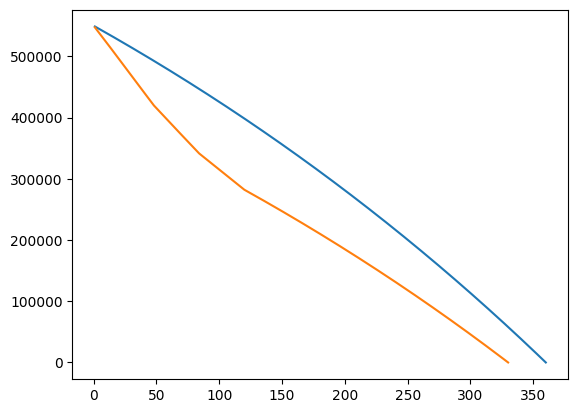

In [312]:
plt.plot(standard_df['Payment Number'], standard_df['Remaining Balance'], label='Standard Amortization')
plt.plot(advance_df['Payment Number'], advance_df['Remaining Balance'], label='Advanced Amortization')

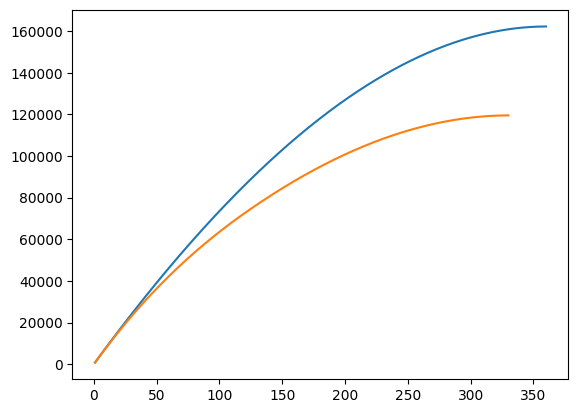

In [313]:
plt.plot(standard_df['Payment Number'], standard_df['Accrued Interest'], label='Standard Amortization')
plt.plot(advance_df['Payment Number'], advance_df['Accrued Interest'], label='Advanced Amortization')